##### Copyright 2024 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import os
from dotenv import load_dotenv

# Cargar las variables del archivo .env
load_dotenv()

# Obtener la API KEY
API_KEY = os.getenv("GOOGLE_API_KEY")



# Anomaly detection with embeddings

<table align="left">
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Anomaly_detection_with_embeddings.ipynb"><img src="https://github.com/google-gemini/cookbook/blob/main/images/colab_logo_32px.png?raw=1" />Run in Google Colab</a>
  </td>
</table>

## Overview

This tutorial demonstrates how to use the embeddings from the Gemini API to detect potential outliers in your dataset. You will visualize a subset of the 20 Newsgroup dataset using [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) and detect outliers outside a particular radius of the central point of each categorical cluster.


In [3]:
%pip install -U -q "google-genai>=1.0.0"

Note: you may need to restart the kernel to use updated packages.


To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb) quickstart for an example.

In [4]:
# Used to securely store your API key
from google import genai
client = genai.Client(api_key=API_KEY)

## Prepare dataset

The [20 Newsgroups Text Dataset](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset) from the open-source [SciKit project](https://scikit-learn.org/) contains 18,000 newsgroups posts on 20 topics divided into training and test sets. The split between the training and test datasets are based on messages posted before and after a specific date. This tutorial uses the training subset.

In [5]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset="train")

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Here is the first example in the training set.

In [6]:
idx = newsgroups_train.data[0].index("Lines")
print(newsgroups_train.data[0][idx:])

Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [7]:
import re

# Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
newsgroups_train.data = [
    re.sub(r"[\w\.-]+@[\w\.-]+", "", d) for d in newsgroups_train.data
]  # Remove email
newsgroups_train.data = [
    re.sub(r"\([^()]*\)", "", d) for d in newsgroups_train.data
]  # Remove names
newsgroups_train.data = [
    d.replace("From: ", "") for d in newsgroups_train.data
]  # Remove "From: "
newsgroups_train.data = [
    d.replace("\nSubject: ", "") for d in newsgroups_train.data
]  # Remove "\nSubject: "

# Cut off each text entry after 5,000 characters
newsgroups_train.data = [
    d[0:5000] if len(d) > 5000 else d for d in newsgroups_train.data
]

In [8]:
import pandas as pd

# Put training points into a dataframe
df_train = pd.DataFrame(newsgroups_train.data, columns=["Text"])
df_train["Label"] = newsgroups_train.target
# Match label to target name index
df_train["Class Name"] = df_train["Label"].map(
    newsgroups_train.target_names.__getitem__
)

df_train

,Text,Label,Class Name
0,WHAT car is this!?\nNntp-Posting-Host: rac3.w...,7,rec.autos
1,SI Clock Poll - Final Call\nSummary: Final ca...,4,comp.sys.mac.hardware
2,PB questions...\nOrganization: Purdue Univers...,4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\nOrganization: Harris Comp...,1,comp.graphics
4,Re: Shuttle Launch Question\nOrganization: Sm...,14,sci.space
...,...,...,...
11309,Re: Migraines and scans\nDistribution: world...,13,sci.med
11310,Screen Death: Mac Plus/512\nLines: 22\nOrganiz...,4,comp.sys.mac.hardware
11311,Mounting CPU Cooler in vertical case\nOrganiz...,3,comp.sys.ibm.pc.hardware
11312,Re: Sphere from 4 points?\nOrganization: Cent...,1,comp.graphics


Next, sample some of the data by taking 150 data points in the training dataset and choosing a few categories. This tutorial uses the science categories.

In [9]:
# Take a sample of each label category from df_train
SAMPLE_SIZE = 150
df_train = (
    df_train.groupby("Label", as_index=False)
    .apply(lambda x: x.sample(SAMPLE_SIZE))
    .reset_index(drop=True)
)

# Choose categories about science
df_train = df_train[df_train["Class Name"].str.contains("sci")]

# Reset the index
df_train = df_train.reset_index()
df_train

/tmp/ipykernel_17343/1132536250.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(SAMPLE_SIZE))


,index,Text,Label,Class Name
0,1650,Why the algorithm is secret\nDistribution: na...,11,sci.crypt
1,1651,Re: Hard drive security for FBI targets\nLine...,11,sci.crypt
2,1652,"Re: Would ""clipper"" make a good cover for oth...",11,sci.crypt
3,1653,"Bob ""Putz"" Cain \nNntp-Posting-Host: next7.c...",11,sci.crypt
4,1654,Re: Do we need the clipper for cheap securit...,11,sci.crypt
...,...,...,...,...
595,2245,Re: Boom! Whoosh......\nOrganization: The Do...,14,sci.space
596,2246,Re: Vandalizing the sky.\nOrganization: Univ....,14,sci.space
597,2247,Re: Soviet Space Book\nReply-To: \nOrganizati...,14,sci.space
598,2248,Re: Why not give $1 billion to first year-lon...,14,sci.space


In [10]:
df_train["Class Name"].value_counts()

Class Name
sci.crypt          150
sci.electronics    150
sci.med            150
sci.space          150
Name: count, dtype: int64

## Create the embeddings

In this section, you will see how to generate embeddings for the different texts in the dataframe using the embeddings from the Gemini API.

### API changes to Embeddings with model embedding-001

For the embeddings model, `text-embedding-004`, there is a task type parameter and the optional title (only valid with task_type=`RETRIEVAL_DOCUMENT`).

These parameters apply only to the embeddings models. The task types are:

Task Type | Description
---       | ---
RETRIEVAL_QUERY	| Specifies the given text is a query in a search/retrieval setting.
RETRIEVAL_DOCUMENT | Specifies the given text is a document in a search/retrieval setting.
SEMANTIC_SIMILARITY	| Specifies the given text will be used for Semantic Textual Similarity (STS).
CLASSIFICATION	| Specifies that the embeddings will be used for classification.
CLUSTERING	| Specifies that the embeddings will be used for clustering.

In [11]:
from tqdm.auto import tqdm
from google.genai import types

tqdm.pandas()

from google.api_core import retry
import numpy as np
import math


def make_embed_text_fn(model):

    @retry.Retry(timeout=300.0)
    def embed_fn(texts: list[str]) -> list[list[float]]:
        # Set the task_type to CLUSTERING and embed the batch of texts
        embeddings = client.models.embed_content(
            model=model,
            contents=texts,
            config=types.EmbedContentConfig(task_type="CLUSTERING"),
        ).embeddings
        return np.array([embedding.values for embedding in embeddings])

    return embed_fn


def create_embeddings(df):
    MODEL_ID = "text-embedding-004" # @param ["embedding-001","text-embedding-004"] {allow-input: true}
    model = f"models/{MODEL_ID}"
    embed_fn = make_embed_text_fn(model)

    batch_size = 100  # at most 100 requests can be in one batch
    all_embeddings = []

    # Loop over the texts in chunks of batch_size
    for i in tqdm(range(0, len(df), batch_size)):
        batch = df["Text"].iloc[i : i + batch_size].tolist()
        embeddings = embed_fn(batch)
        all_embeddings.extend(embeddings)

    df["Embeddings"] = all_embeddings
    return df


df_train = create_embeddings(df_train)
df_train.drop("index", axis=1, inplace=True)

  0%|          | 0/6 [00:00<?, ?it/s]

## Dimensionality reduction

The dimension of the document embedding vector is 768. In order to visualize how the embedded documents are grouped together, you will need to apply dimensionality reduction as you can only visualize the embeddings in 2D or 3D space. Contextually similar documents should be closer together in space as opposed to documents that are not as similar.

In [12]:
len(df_train["Embeddings"][0])

768

In [13]:
# Convert df_train['Embeddings'] Pandas series to a np.array of float32
X = np.array(df_train["Embeddings"].to_list(), dtype=np.float32)
X.shape

(600, 768)

You will apply the t-Distributed Stochastic Neighbor Embedding (t-SNE) approach to perform dimensionality reduction. This technique reduces the number of dimensions, while preserving clusters (points that are close together stay close together). For the original data, the model tries to construct a distribution over which other data points are "neighbors" (e.g., they share a similar meaning). It then optimizes an objective function to keep a similar distribution in the visualization.

In [14]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=0, max_iter=1000)
tsne_results = tsne.fit_transform(X)

In [15]:
df_tsne = pd.DataFrame(tsne_results, columns=["TSNE1", "TSNE2"])
df_tsne["Class Name"] = df_train[
    "Class Name"
]  # Add labels column from df_train to df_tsne
df_tsne

,TSNE1,TSNE2,Class Name
0,22.076654,-3.293950,sci.crypt
1,10.074988,-0.676578,sci.crypt
2,24.760523,-4.813555,sci.crypt
3,26.363600,7.402662,sci.crypt
4,21.677071,-7.481381,sci.crypt
...,...,...,...
595,-12.765013,8.553514,sci.space
596,-11.688429,10.822495,sci.space
597,-14.214967,-1.767647,sci.space
598,-18.382233,15.959096,sci.space


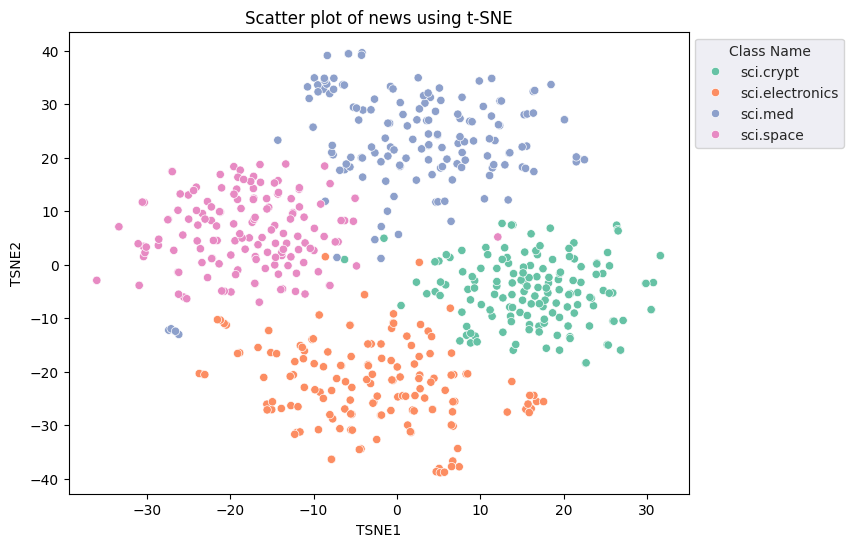

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 6))  # Set figsize
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2", hue="Class Name", palette="Set2")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Scatter plot of news using t-SNE")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2");

## Outlier detection

To determine which points are anomalous, you will determine which points are inliers and outliers. Start by finding the centroid, or location that represents the center of the cluster, and use the distance to determine the points that are outliers.

Start by getting the centroid of each category.

In [17]:
def get_centroids(df_tsne):
    # Get the centroid of each cluster
    centroids = df_tsne.groupby("Class Name").mean()
    return centroids


centroids = get_centroids(df_tsne)
centroids

,TSNE1,TSNE2
Class Name,,
sci.crypt,16.617275,-4.895742
sci.electronics,-3.075279,-22.110899
sci.med,2.388335,23.206116
sci.space,-18.218239,5.998891


In [18]:
def get_embedding_centroids(df):
    emb_centroids = dict()
    grouped = df.groupby("Class Name")
    for c in grouped.groups:
        sub_df = grouped.get_group(c)
        # Get the centroid value of dimension 768
        emb_centroids[c] = np.mean(sub_df["Embeddings"], axis=0)

    return emb_centroids

In [19]:
emb_c = get_embedding_centroids(df_train)

Plot each centroid you have found against the rest of the points.

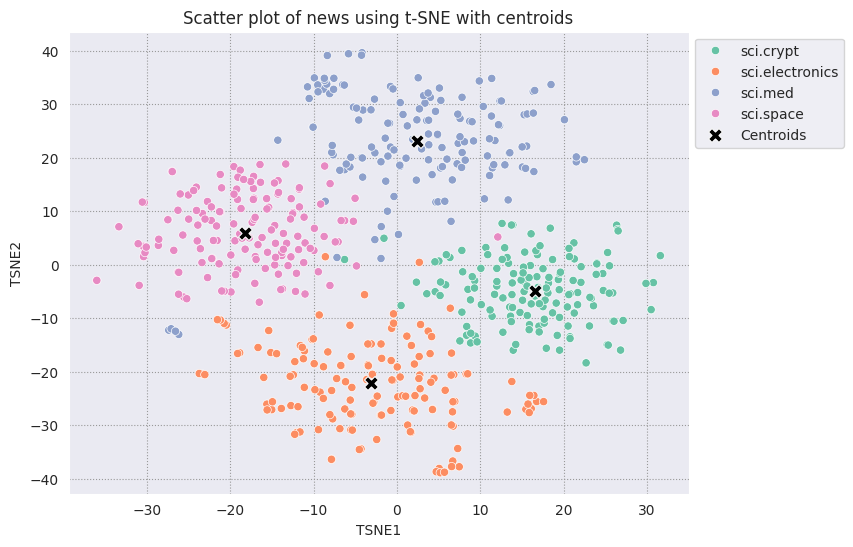

In [20]:
# Plot the centroids against the cluster
fig, ax = plt.subplots(figsize=(8, 6))  # Set figsize
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2", hue="Class Name", palette="Set2")
sns.scatterplot(
    data=centroids,
    x="TSNE1",
    y="TSNE2",
    color="black",
    marker="X",
    s=100,
    label="Centroids",
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Scatter plot of news using t-SNE with centroids")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2");

Choose a radius. Anything beyond this bound from the centroid of that category is considered an outlier.

In [21]:
def calculate_euclidean_distance(p1, p2):
    return np.sqrt(np.sum(np.square(p1 - p2)))


def detect_outlier(df, emb_centroids, radius):
    for idx, row in df.iterrows():
        class_name = row["Class Name"]  # Get class name of row
        # Compare centroid distances
        dist = calculate_euclidean_distance(
            row["Embeddings"], emb_centroids[class_name]
        )
        df.at[idx, "Outlier"] = dist > radius

    return len(df[df["Outlier"] == True])

In [22]:
range_ = np.arange(0.3, 0.75, 0.02).round(decimals=2).tolist()
num_outliers = []
for i in range_:
    num_outliers.append(detect_outlier(df_train, emb_c, i))

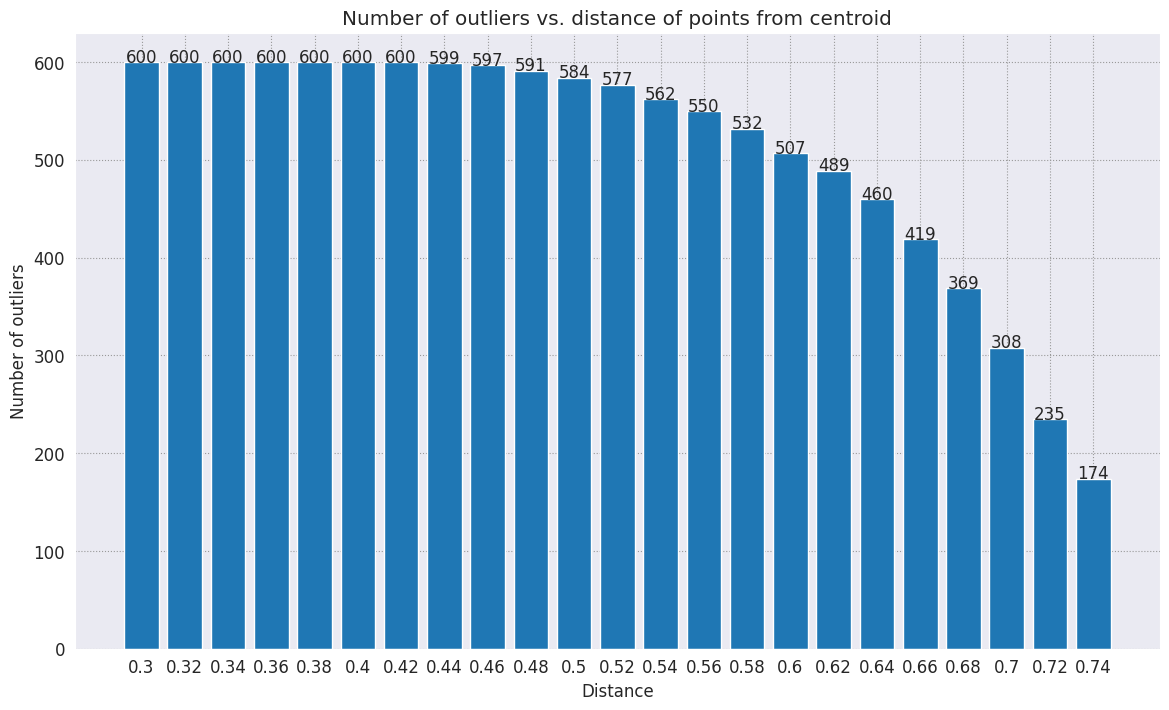

In [23]:
# Plot range_ and num_outliers
fig = plt.figure(figsize=(14, 8))
plt.rcParams.update({"font.size": 12})
plt.bar(list(map(str, range_)), num_outliers)
plt.title("Number of outliers vs. distance of points from centroid")
plt.xlabel("Distance")
plt.ylabel("Number of outliers")
for i in range(len(range_)):
    plt.text(i, num_outliers[i], num_outliers[i], ha="center")

plt.show()

Depending on how sensitive you want your anomaly detector to be, you can choose which radius you would like to use. For now, 0.62 is used, but you can change this value.

In [24]:
# View the points that are outliers
RADIUS = 0.62
detect_outlier(df_train, emb_c, RADIUS)
df_outliers = df_train[df_train["Outlier"] == True]
df_outliers.head()

,Text,Label,Class Name,Embeddings,Outlier
0,Why the algorithm is secret\nDistribution: na...,11,sci.crypt,"[0.042236883, 0.04244476, -0.019720826, 0.0847...",True
1,Re: Hard drive security for FBI targets\nLine...,11,sci.crypt,"[-0.0315082, -0.0022232428, 0.0018684068, 0.01...",True
3,"Bob ""Putz"" Cain \nNntp-Posting-Host: next7.c...",11,sci.crypt,"[0.002561612, 0.021269692, -0.033868685, -0.00...",True
8,Cryptology in the world\nKeywords: cryptology...,11,sci.crypt,"[-0.0537982, 0.030313363, -0.04314692, -0.0121...",True
10,Re: Re-inventing Crypto Policy? An EFF State...,11,sci.crypt,"[0.06840413, -0.011644697, -0.05390163, 0.0353...",True


In [25]:
# Use the index to map the outlier points back to the projected TSNE points
outliers_projected = df_tsne.loc[df_outliers["Outlier"].index]

Plot the outliers and denote them using a transparent red color.

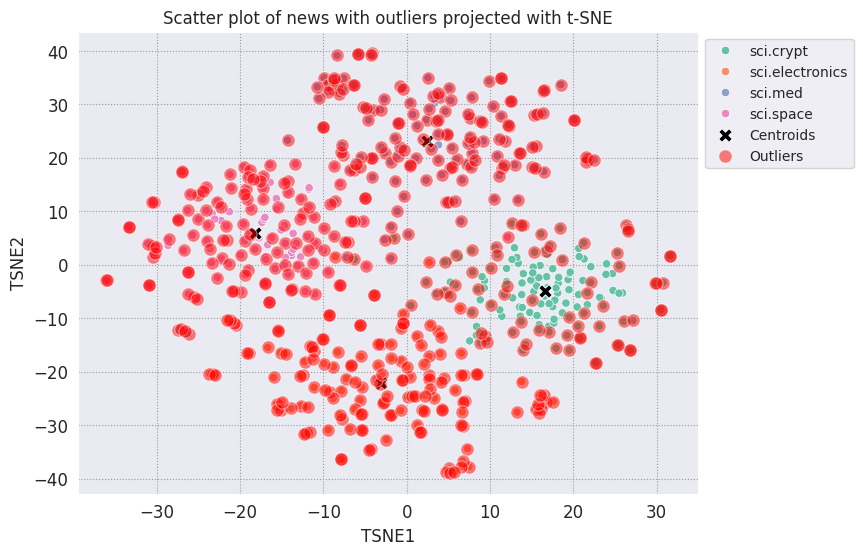

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))  # Set figsize
plt.rcParams.update({"font.size": 10})
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2", hue="Class Name", palette="Set2")
sns.scatterplot(
    data=centroids,
    x="TSNE1",
    y="TSNE2",
    color="black",
    marker="X",
    s=100,
    label="Centroids",
)
# Draw a red circle around the outliers
sns.scatterplot(
    data=outliers_projected,
    x="TSNE1",
    y="TSNE2",
    color="red",
    marker="o",
    alpha=0.5,
    s=90,
    label="Outliers",
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Scatter plot of news with outliers projected with t-SNE")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2");

Use the index values of the datafames to print a few examples of what outliers can look like in each category. Here, the first data point from each category is printed out. Explore other points in each category to see data that are deemed as outliers, or anomalies.

In [27]:
sci_crypt_outliers = df_outliers[df_outliers["Class Name"] == "sci.crypt"]
print(sci_crypt_outliers["Text"].iloc[0])

 Why the algorithm is secret
Distribution: na
Organization: Center For High Perf. Computing of WPI; Marlboro Ma
Lines: 15


My thoughts on why the algorithm is secret :

   The chip is  likely to become a standard.   There will
   be many applications where economic factors dictate use of this
   chip, like it or not.

   If the alrogithm is public, and the code is as secure  as represented, an enterprising sort 
   would make "compatible crypto chips for which no key had been
   escrowed".  This is likely what the release was refering to when 
   they refered to the secrecy of the algorithm protecting the
   security of the escrow system.

                                        rob boudrie



In [28]:
sci_elec_outliers = df_outliers[df_outliers["Class Name"] == "sci.electronics"]
print(sci_elec_outliers["Text"].iloc[0])

Mike Diack <>Re: RAMs &ROMs with ALE latches 
X-Xxdate: Wed, 21 Apr 93 03:04:18 GMT
Nntp-Posting-Host: dialup-slip-1-88.gw.umn.edu
Organization: persian cat & carpet co.
X-Useragent: Nuntius v1.1.1d7
Lines: 15

In article <> j. pethybridge,
 writes:
> I asked this a year ago, but i am still looking.
> I am getting sick of having to use a HC373 or a 8751/2.
Check out Xicor's new goodie in the April 12th edition of EETimes
X88C64 - an 8k * 8 E2PROM with built in latch AND bootloader setup.
You hook it directly to your '51, power it up, the prom initialises the
serial port on the '51, you load in your code via RXD, this gets blatted
onto the E2PROM, then you reset and run - i'm sure Dallas also does
something like this too, i suppose it would boil down to relative
prices, and the Dallas part freeing up P0 & P2 completely. I wonder
if ANYONE has ever managed to design a single sided PCB with an
8051, 573, EPROM, SRAM and >>NO LINKS<< ?
cheers
Mike.



In [29]:
sci_med_outliers = df_outliers[df_outliers["Class Name"] == "sci.med"]
print(sci_med_outliers["Text"].iloc[0])

 Re: sore throat
Reply-To:  
Organization: GEC-Marconi Research Centre, Great Baddow, UK
Lines: 29

In article <>   writes:
>I have had a sore throat for almost a week.  When I look into
>the mirror with the aid of a flash light, I see white plaques in
>the very back of my throat .  I went to a health
>center to have a throat culture taken.  They said that I do not
>have strep throat.  Could a viral infection cause white plaques
>on the sides of my throat?

First, I am not a doctor.  I know about this because I have been
through it.

It sounds like tonsilitis .  Feel under your jaw
hinge for a swelling on each side.  If you find them, its tonsilitis.
I've had this a couple of times in the past.  The doctor prescribed a
weeks course of penicillin and that cleared it up.

In my case it was associated with glandular fever, which is a viral
infection which  resembled flu and tonsilitis
that kept coming back for a year or so.  There is a blood test for
this.

In conclusion, see a doctor .



In [30]:
sci_space_outliers = df_outliers[df_outliers["Class Name"] == "sci.space"]
print(sci_space_outliers["Text"].iloc[0])

 Vast Bandwidth Over-runs on NASA thread 
In-Reply-To: wingo%'s message of 18 Apr 1993 13:56 CDT
Originator: 
Nntp-Posting-Host: snow.fox.cs.cmu.edu
Organization: School of Computer Science, Carnegie Mellon University
	<> <>
	<>
Lines: 12

In article <>, Dennis writes about a
zillion lines in response to article <>,
in which Allen wrote a zillion lines in response to article
<>, in which Dennis wrote another zillion
lines in response to Allen.

Hey, can it you guys. Take it to email, or talk.politics.space, or
alt.flame, or alt.music.pop.will.eat.itself.the.poppies.are.on.patrol,
or anywhere, but this is sci.space. This thread lost all scientific
content many moons ago.

Nick Haines 



## Next steps

You've now created an anomaly detector using embeddings! Try using your own textual data to visualize them as embeddings, and choose some bound such that you can detect outliers. You can perform dimensionality reduction in order to complete the visualization step. Note that t-SNE is good at clustering inputs, but can take a longer time to converge or might get stuck at local minima. If you run into this issue, another technique you could consider are [principal components analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis).

# **1. ¿Qué se debe considerar al momento de elegir entre sensitividad y precisión del umbral?**
### Con la sensibilidad, se consideraria priorizar si es crucial detectar la mayoría de los casos positivos.
# La presicion se considera mas preferible para evitar o minimizar falsosfalsos positivos (ej. fraudes, costos operativos).
# Se podria realizar un ajuste del umbral según F1-score si ambos errores son críticos. Esto porque un umbral bajo
# aumenta falsos positivos; uno alto, falsos negativos. No conviene tener equivocaciones, al menos, no una cantidad
# alarmante de clasificaciones erroneas.


Ejecutando DBSCAN...
Ejecutando Isolation Forest...


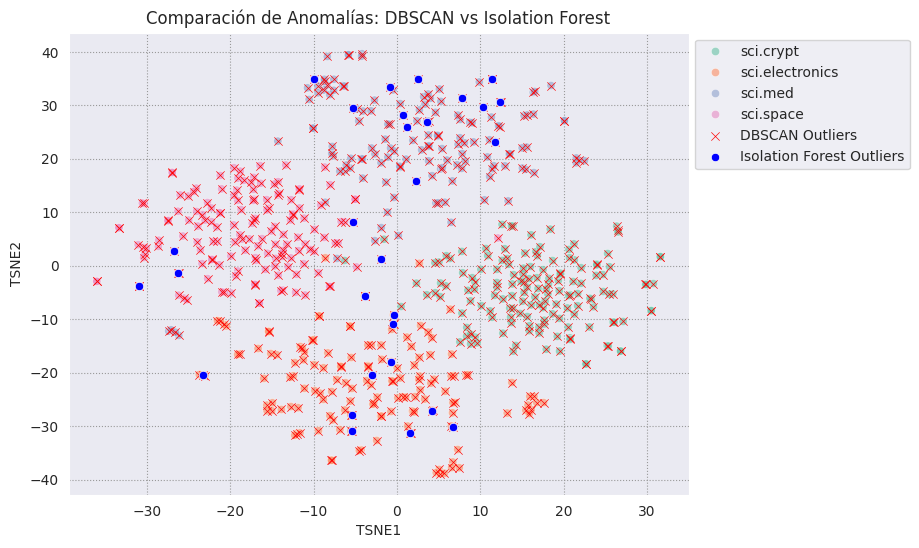

Ejemplo de anomalía detectada por DBSCAN:
 Why the algorithm is secret
Distribution: na
Organization: Center For High Perf. Computing of WPI; Marlboro Ma
Lines: 15


My thoughts on why the algorithm is secret :

   The chip is  likely to become a standard.   There will
   be many applications where economic factors dictate use of this
   chip, like it or not.

   If the alrogithm is public, and the code is as secure  as represented, an enterprising sort 
   would make "compatible crypto chips for which no key had been
   escrowed".  This is likely what the release was refering to when 
   they refered to the secrecy of the algorithm protecting the
   security of the escrow system.

                                        rob boudrie

Ejemplo de anomalía detectada por Isolation Forest:
 Re: Exploding TV!
Organization: The University of British Columbia
Lines: 4
Distribution: usa
NNTP-Posting-Host: unixg.ubc.ca

 Just as a not of possible interest on this subject ..
It is my understandin

In [31]:
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir las embeddings en un array numpy
X = np.array(df_train["Embeddings"].to_list(), dtype=np.float32)

# --- MÉTODO 1: DBSCAN ---
print("Ejecutando DBSCAN...")
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X)
df_train["DBSCAN_Outlier"] = dbscan_labels == -1  # -1 indica outliers

# --- MÉTODO 2: Isolation Forest ---
print("Ejecutando Isolation Forest...")
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest_labels = iso_forest.fit_predict(X)
df_train["IF_Outlier"] = iso_forest_labels == -1  # -1 indica outliers

# --- VISUALIZACIÓN DE OUTLIERS ---
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2", hue="Class Name", palette="Set2", alpha=0.6)
sns.scatterplot(data=df_tsne[df_train["DBSCAN_Outlier"]], x="TSNE1", y="TSNE2", color="red", marker="x", label="DBSCAN Outliers")
sns.scatterplot(data=df_tsne[df_train["IF_Outlier"]], x="TSNE1", y="TSNE2", color="blue", marker="o", label="Isolation Forest Outliers")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Comparación de Anomalías: DBSCAN vs Isolation Forest")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

# Mostrar algunas anomalías detectadas
dbscan_outliers = df_train[df_train["DBSCAN_Outlier"]]
iso_forest_outliers = df_train[df_train["IF_Outlier"]]

print("Ejemplo de anomalía detectada por DBSCAN:")
print(dbscan_outliers.iloc[0]["Text"])

print("Ejemplo de anomalía detectada por Isolation Forest:")
print(iso_forest_outliers.iloc[0]["Text"])


In [34]:
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir las embeddings en un array numpy
X = np.array(df_train["Embeddings"].to_list(), dtype=np.float32)


In [35]:
# --- REDUCCIÓN DE DIMENSIONALIDAD: PCA ---
print("Ejecutando PCA...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df_train["PCA1"], df_train["PCA2"] = X_pca[:, 0], X_pca[:, 1]


Ejecutando PCA...


In [36]:
# --- REDUCCIÓN DE DIMENSIONALIDAD: t-SNE ---
print("Ejecutando t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)
df_train["TSNE1"], df_train["TSNE2"] = X_tsne[:, 0], X_tsne[:, 1]


Ejecutando t-SNE...


In [37]:
# --- MÉTODO 1: DBSCAN ---
print("Ejecutando DBSCAN...")
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X)
df_train["DBSCAN_Outlier"] = dbscan_labels == -1  # -1 indica outliers


Ejecutando DBSCAN...


In [38]:
# --- MÉTODO 2: Isolation Forest ---
print("Ejecutando Isolation Forest...")
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest_labels = iso_forest.fit_predict(X)
df_train["IF_Outlier"] = iso_forest_labels == -1  # -1 indica outliers


Ejecutando Isolation Forest...


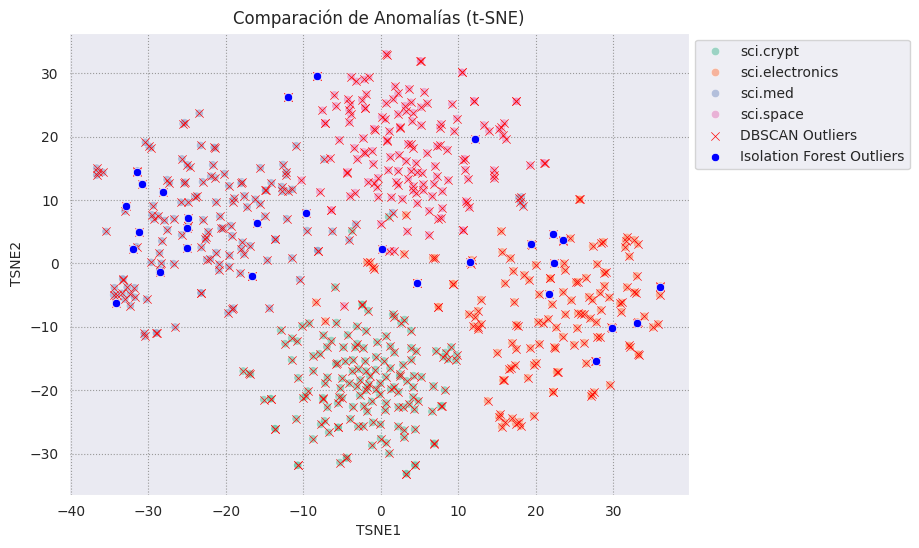

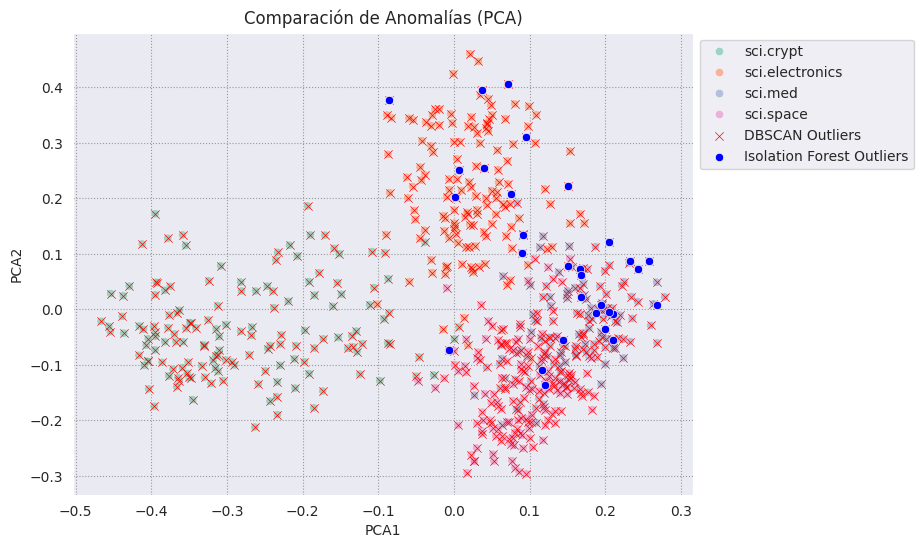

In [39]:
# --- VISUALIZACIÓN DE OUTLIERS (t-SNE) ---
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=df_train, x="TSNE1", y="TSNE2", hue="Class Name", palette="Set2", alpha=0.6)
sns.scatterplot(data=df_train[df_train["DBSCAN_Outlier"]], x="TSNE1", y="TSNE2", color="red", marker="x", label="DBSCAN Outliers")
sns.scatterplot(data=df_train[df_train["IF_Outlier"]], x="TSNE1", y="TSNE2", color="blue", marker="o", label="Isolation Forest Outliers")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Comparación de Anomalías (t-SNE)")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

# --- VISUALIZACIÓN DE OUTLIERS (PCA) ---
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=df_train, x="PCA1", y="PCA2", hue="Class Name", palette="Set2", alpha=0.6)
sns.scatterplot(data=df_train[df_train["DBSCAN_Outlier"]], x="PCA1", y="PCA2", color="red", marker="x", label="DBSCAN Outliers")
sns.scatterplot(data=df_train[df_train["IF_Outlier"]], x="PCA1", y="PCA2", color="blue", marker="o", label="Isolation Forest Outliers")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Comparación de Anomalías (PCA)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()


In [40]:
# Mostrar algunas anomalías detectadas
dbscan_outliers = df_train[df_train["DBSCAN_Outlier"]]
iso_forest_outliers = df_train[df_train["IF_Outlier"]]

print("Ejemplo de anomalía detectada por DBSCAN:")
print(dbscan_outliers.iloc[0]["Text"])

print("Ejemplo de anomalía detectada por Isolation Forest:")
print(iso_forest_outliers.iloc[0]["Text"])


Ejemplo de anomalía detectada por DBSCAN:
 Why the algorithm is secret
Distribution: na
Organization: Center For High Perf. Computing of WPI; Marlboro Ma
Lines: 15


My thoughts on why the algorithm is secret :

   The chip is  likely to become a standard.   There will
   be many applications where economic factors dictate use of this
   chip, like it or not.

   If the alrogithm is public, and the code is as secure  as represented, an enterprising sort 
   would make "compatible crypto chips for which no key had been
   escrowed".  This is likely what the release was refering to when 
   they refered to the secrecy of the algorithm protecting the
   security of the escrow system.

                                        rob boudrie

Ejemplo de anomalía detectada por Isolation Forest:
 Re: Exploding TV!
Organization: The University of British Columbia
Lines: 4
Distribution: usa
NNTP-Posting-Host: unixg.ubc.ca

 Just as a not of possible interest on this subject ..
It is my understandin